In [1]:
# Importamos las librerías y clases necesarias
import numpy as np
from qiskit.circuit import QuantumRegister, ClassicalRegister,QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.quantum_info import Statevector

# Import para visualización
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex

In [2]:
# Importamos el simulador. Con "method" le especificamos el método de simulación
simulador = AerSimulator(method = 'statevector')

In [3]:
def random_linear_oracle(n):  #n es la longitud de la cadena a oculta

    import random, string
    a = ''.join(random.choices(['0','1'], k=n))
    print('cadena oculta=',a)  
    qc = QuantumCircuit(n+1) # el ultimo registro es la salida |f(x)> = |a.x>

    
    for i, ai in enumerate(reversed(a)):  # ponemos reversed para usar el convenio de qiskit
        if ai == '1':
            qc.cx(i,n)    
    return qc

random_linear_oracle(4).draw()

cadena oculta= 0010


q_0: ─────
          
q_1: ──■──
       │  
q_2: ──┼──
       │  
q_3: ──┼──
     ┌─┴─┐
q_4: ┤ X ├
     └───┘

In [4]:
def BV_circuit(linear_oracle,n):
    #n: número de bits
    #a: coeficiente oculto
    #return: circuito

    qreg = QuantumRegister(n+1)
    creg = ClassicalRegister(n)
    qc = QuantumCircuit(qreg,creg)

    #Hacemos máxima superposición
    qc.h(qreg)

    #Ponemos el último qubit en el estado |->
    qc.z(qreg[-1])

    qc.barrier()
    
    # añadimos el oráculo lineal con la cadena oculta
    qc.append(linear_oracle.to_gate(),qreg[:])
    
    qc.barrier()
    

    #Aplicamos Hadamard de nuevo

    qc.h(qreg[0:-1])

    qc.measure(qreg[0:-1],creg)

    return qc

cadena oculta= 0100


/home/dcb/Programs/miniconda/miniconda3/envs/qiskit_qibo_penny_2/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


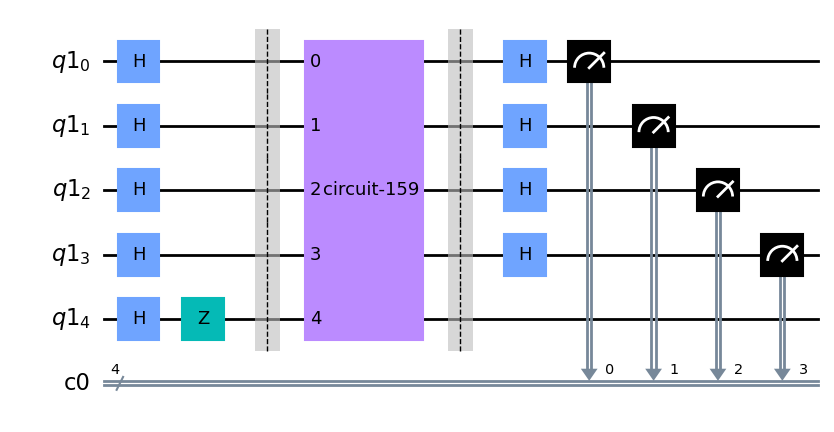

In [5]:
n = 4
linear_oracle = random_linear_oracle(n)

circuito = BV_circuit(linear_oracle,n)

circuito.draw(output = 'mpl')

In [6]:
# transpilamos
t_circuit = transpile(circuito, backend = simulador)

In [7]:
# Ejecutamos la simulación con 1000 shots 
result = simulador.run(t_circuit, shots = 1000).result()
counts = result.get_counts()
counts

{'0100': 1000}

In [8]:
def binary_function(f_outputs): 
 
    from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
    from qiskit.circuit.library import MCXGate

    #claramente el número de n-bits de entrada tiene que ser tal que 2^n acomode el número de salidas de f
    n = int(np.ceil(np.log2(len(f_outputs))))
    
    #sin embargo los outputs pueden tener longitud arbitraria
    m = len(f_outputs[0])
    
    #generamos todos los posibles inputs en binario, completando con ceros hasta tener strings de n bits
    inputs = [format(i, 'b').zfill(n) for i in range(2**n)]
    # verificamos que hay tantos outputs como posibles inputs 
    # assert len(inputs) == len(f_outputs)

    qr_input = QuantumRegister(n)
    qr_output = QuantumRegister(m)
    qc = QuantumCircuit(qr_input, qr_output)


    # Hacemos un bucle sobre los inputs
    for i,input_str in enumerate(inputs[:len(f_outputs)]):
        ctrl_state= int(input_str[::],2)

        # Para cada input, i, hacemos un bucle sobre cada  cúbit del output     
        for j,output_bit in enumerate(f_outputs[i]):
###
            if output_bit =='1':
                qc.append(MCXGate(len(input_str), ctrl_state=ctrl_state),qr_input[:]+[qr_output[n-j-1]])
#  
###

    return qc

In [9]:
# promesa: esta función contiene un periodo binario
f_outputs = ['1111', '1011', '0011', '1000', '0101', '0100', 
               '0000', '1110', '0101', '0100', '0000', '1110', 
               '1111', '1011', '0011', '1000']

# creamos el oráculo y lo transformamos en una puerta 
simon_oracle_gate = binary_function(f_outputs).to_gate()

# verificamos que se trata de una función de n en n bits
n_input = int(np.log2(len(f_outputs))) #número de outputs
m_output =len(f_outputs[0])            #longitud de cada output
assert(n_input == m_output)